In [5]:
#　解析に使用する定数の定義
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter
from scipy.signal import argrelmin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN
from scipy import signal
import os
import itertools
import functools
import glob
import numpy as np

In [2]:
raw_path = "C:/Users/Imaris/Desktop/watanabe/250801/リポジトリ/test.raw"
print("raw_path", raw_path)

raw_path C:/Users/Imaris/Desktop/watanabe/250801/リポジトリ/test.raw


In [3]:
import os

folder_name = "C:/Users/Imaris/Desktop/watanabe/250801/リポジトリ"

spike_detects = folder_name + "/" + "spike_detect"
pca =  folder_name + "/" + "pca"
sorting_cluster =  folder_name + "/" + "sorting_cluster"
auto_correlo =  folder_name + "/" + "auto_correlo"

for folder_name in [spike_detects, pca, sorting_cluster, auto_correlo]:
    # フォルダが存在しない場合のみ作成する
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"フォルダ '{folder_name}' を作成しました。")
    else:
        print(f"フォルダ '{folder_name}' は既に存在します。")

フォルダ 'C:/Users/Imaris/Desktop/watanabe/250801/リポジトリ/spike_detect' を作成しました。
フォルダ 'C:/Users/Imaris/Desktop/watanabe/250801/リポジトリ/pca' を作成しました。
フォルダ 'C:/Users/Imaris/Desktop/watanabe/250801/リポジトリ/sorting_cluster' を作成しました。
フォルダ 'C:/Users/Imaris/Desktop/watanabe/250801/リポジトリ/auto_correlo' を作成しました。


In [6]:
# raw dataからtrigger情報を取得
#import numpy as np

def TRGfromDAT(dat_path, sampling_rate=20000, CHANNEL_NUM = 61, CHANNEL_TRG = 0):
    dat = np.fromfile(dat_path,dtype='h').reshape(-1,CHANNEL_NUM)
    trg_column = dat[:,CHANNEL_TRG]
    not_saturate = np.where(trg_column != trg_column.max())[0] #search unsaturated range 
    temp_trg = np.diff(not_saturate)
    temp_trg_index = np.where(temp_trg != 1)[0] + 1 #search uncontinous index from unsaturated range 
    trg_index = np.r_[0,temp_trg_index]
    trg_array = not_saturate[trg_index] / sampling_rate
    return trg_array

# raw dataから1ch分の情報を取得
#import numpy as np

def ReadRawFile(path, channel, CHANNEL_NUM = 61):
    raw = np.fromfile(path,dtype='h').reshape(-1,CHANNEL_NUM)
    # print('raw.shape', raw.shape)
    return raw[:,CH_ARRAY==channel][:,0]


def BandPassFilter(wave_raw, bottom=300, top=3000, sampling_rate=20000):
    nyq = sampling_rate / 2
    cutoff = np.array([bottom, top]) / nyq
    numtaps = 255
    bpf = firwin(numtaps, cutoff, pass_zero=False)
    return lfilter(bpf, 1, wave_raw)[int((numtaps-1)/2):]

def SpikeDetection(wave_filtered, sd_thr=4, order=15, spike=-1):
    peaks = argrelmin(-1*spike*wave_filtered, order=order)[0]
    #選別用の閾値の計算
    ##median
    median = np.median(wave_filtered)
    threshold = median - sd_thr * (np.median(abs(wave_filtered - median)) / 0.6745)
    # print('Threshold: ', threshold)
    #スパイクの選別
    spike_index = peaks[wave_filtered[peaks] < threshold]
    # print('Peak number: ', spike_index.size)
    return spike_index


def MakeWaveShape(temp_wave_array):
    return np.arange(temp_wave_array[0], temp_wave_array[1])

def GetWaveShape(spike_index, wave_filtered, area_before_peak_ms=1, area_after_peak_ms=2, sampling_rate=20000, ms=1000):
    area_before_peak_index = int(area_before_peak_ms * sampling_rate / ms)
    area_after_peak_index = int(area_after_peak_ms * sampling_rate / ms)
    temp_wave_array = np.c_[spike_index-area_before_peak_index, spike_index+area_after_peak_index]
    wave_array = np.array(list(map(MakeWaveShape, temp_wave_array)))

    unuse_peak_index_1 = np.where(wave_array[:,-1] > wave_filtered.size-40)[0]
    unuse_peak_index_2 = np.where(wave_array[:,0] < 0)[0]
    wave_array = np.delete(wave_array, np.r_[unuse_peak_index_1,unuse_peak_index_2], axis=0)
    spike_index = np.delete(spike_index, np.r_[unuse_peak_index_1,unuse_peak_index_2], axis=0)

    spike_shape = wave_filtered[wave_array]
    # print('Wave_Shape.shape :', spike_shape.shape)
    return spike_shape, spike_index

def CutWaveShape(spike_shape, area=13):
#     roi = np.arange(spike_shape.shape[1]/3 - area, spike_shape.shape[1]/3 + 2*area + 1).astype(np.int)
    roi = np.arange(
    spike_shape.shape[1] / 3 - area, 
    spike_shape.shape[1] / 3 + 2 * area + 1
).astype(int)
    return spike_shape[:,roi]

def DimensionalityReductionWithDiff1(features, n_comp):
    features_diff = np.diff(features, n=1)
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(features_diff)
    return X_pca, pca.explained_variance_ratio_

def DimensionalityReductionWithDiffs(features, n_comp):
    features_diff = np.c_[np.diff(features, n=1), np.diff(features, n=2)]
    pca = PCA(n_components=features.shape[1])
    X_pca = pca.fit_transform(features_diff)
    return X_pca[:,:int(n_comp)], pca.explained_variance_ratio_[:int(n_comp)]


# def ClusteringWithHDBSCAN(spike_feature, clu_size=2500, min_sam=250,cor_num=4, lea_siz=100): 
#     try:
#         clusters = HDBSCAN(min_cluster_size=clu_size, min_samples=min_sam, leaf_size=lea_siz,
#                            cluster_selection_method='leaf',core_dist_n_jobs=cor_num).fit_predict(spike_feature)
#         return clusters
#     except ValueError:
#         print('There was ValueError!! So now using eom!!!')
#         hdbscan = HDBSCAN(min_cluster_size=10, min_samples=100, core_dist_n_jobs=cor_num,allow_single_cluster=True)
#         hdbscan.fit(spike_feature)
#         clusters = hdbscan.labels_
#         clusters[hdbscan.probabilities_ < 0.3] = -1
#         return clusters
#     except:
#         print('Any Error Were Occured!!!')
#         return 0

def ClusteringWithHDBSCAN(spike_feature, clu_size=2000, min_sam=250,cor_num=1, lea_siz=100): 
        try:
            clusters = HDBSCAN(min_cluster_size=clu_size, min_samples=min_sam, leaf_size=lea_siz,
                               cluster_selection_method='leaf',core_dist_n_jobs=cor_num).fit_predict(spike_feature)
#             print("pjifea")
            if(np.unique(clusters).shape[0] == 1):
                raise ValueError
#             print("あ")
            return clusters
        except ValueError:
            try:
                clusters = HDBSCAN(min_cluster_size=320, min_samples=10, leaf_size=lea_siz,
                                        cluster_selection_method='leaf',core_dist_n_jobs=cor_num, allow_single_cluster=True).fit_predict(spike_feature)
                if(np.unique(clusters).shape[0] == 1):
                    raise ValueError
#                 print("い")
                return clusters
            except ValueError:
                print('There was ValueError!! So now using eom!!!')
                hdbscan = HDBSCAN(min_cluster_size=10, min_samples=100, core_dist_n_jobs=cor_num,allow_single_cluster=True)
                hdbscan.fit(spike_feature)
                clusters = hdbscan.labels_
                clusters[hdbscan.probabilities_ < 0.3] = -1

                return clusters
            except:
                print('Any Error Were Occured!!!')
                return clusters

        except:
            print('Any Error Were Occured!!!')

            return 0

from scipy import signal
import os


def CalcACR(spike_time):
    #変数の定義
    window_auto = 1000
    binWidth_auto = 1 #[ms]
    #格納先の作成
    bin_num = int(((window_auto * 2)/binWidth_auto) + 1)
    hist_auto = np.zeros(bin_num)
    isi_size = spike_time.size
    ##ex) spike_time_all = [1,3,10,100,2100]
    for mid_search in spike_time:
        ##1週目
        #mid_serch = 1
        # left_end = 1 - 1000 = -999 (ms)
        left_end = mid_search - window_auto
        #right_end = 1 + 1000 = 1001 (ms)
        right_end = mid_search + window_auto
        # -999(ms) ~  1001(ms)の間に存在するスパイク発火のインデックスをindex_serchに格納
        #該当するスパイク　 1, 3, 10, 100 　＊ spike_time_all内のスパイク発火時間
        #index_search = 0,1,2,3
        index_search = np.where((spike_time >= left_end)&(spike_time <= right_end))[0]
        #spike_time_all[index_search] = 1,3,10
        #temp_spike_time - 1 = 0, 2, 9
        temp_spike_time = spike_time[index_search] - mid_search
        #ヒストグラム書く
        hist_auto += np.histogram(temp_spike_time, bins=bin_num, range=(-window_auto,window_auto))[0]

    return hist_auto  #Norm_Hist_Auto
##############################################

def CalcPOW(acr,ex_file_path=''):
    sampling_rate = 1000
    freq, P = signal.periodogram(x=acr,fs=sampling_rate)
    roi_x_pow = np.array([0,80])
    
    ##オシレーションインデックス算出
    #Search_Area = np.array([5,15]) #5~10Hz
    #PWR_ROI_Index = np.where((freq >= Search_Area[0]) & (PWR[:,0] < Search_Area[1]))[0]
    #PWR_ROI = (np.max(PWR[PWR_ROI_Index,1]) - np.mean(PWR[PWR_ROI_Index,1]))/np.std(PWR[:,1])
    #return np.max(PWR[PWR_ROI_Index,1]), PWR[np.argmax(PWR[PWR_ROI_Index,1])+PWR_ROI_Index[0],0], np.mean(PWR[:,1]), np.std(PWR[:,1]), PWR_ROI
    
    # figure_pow = plt.figure()
    # pow_pointer = figure_pow.add_subplot(1,1,1)
    # pow_pointer.plot(freq,P,color='black')
    # pow_pointer.set_xlim(roi_x_pow)
    # pow_pointer.set_xlabel('Frequency[Hz]')
    # pow_pointer.set_ylabel('Power/frequency')
    # # cell_id = os.path.split(ex_file_path)[1]
    # pow_pointer.set_title(cell_id)
    # #plt.ylim(0, 0.0007)

    # plt.show()
    # plt.clf()
    # plt.close('all')
    
    return np.c_[freq,P]

def JudgeAcr(xAxis, acr):
    #クラスターが自己相関の基準を突破できるか判定
    AllIndex = np.where((xAxis >= -200) & (xAxis <= 200))[0] #-200 ms ~ 200 msのインデックスを取得
    SearchIndex =[998, 999, 1001, 1002] #-2,-1, 1,2 msのインデックスを取得

    AllACR = acr[AllIndex]
    SearchACR = acr[SearchIndex]

    # 基準値算出
    FireIndex = np.sum(SearchACR)/np.sum(AllACR)* 100 
    return FireIndex

def CalcCCR(spike_time1, spike_time2):
    #変数の定義
    #1000 ms
    window_auto = 1000
    #瓶サイズ
    binWidth_auto = 1 #[ms]
    #格納先の作成
    #瓶の数 
    #2000 / 1 + 1 = 2001
    bin_num = int(((window_auto * 2)/binWidth_auto) + 1)
    #2001個の0をhist_autoに格納
    hist_auto = np.zeros(bin_num)
    #全てのスパイク時間

############################################################################################
##変更点1： 
##①spike_time_all ⇨　cell1_spike_time_all，　
##②さらにcell2_spike_time_all = isi[:,2]を追加　
##
############################################################################################
    #スパイク発火の数
    isi_size = spike_time1.size
    ##ex) spike_time_all = [1,3,10,100,2100]
    for mid_search in spike_time1:
        ##1週目
        #mid_serch = 1
        # left_end = 1 - 1000 = -999 (ms)
        left_end = mid_search - window_auto
        #right_end = 1 + 1000 = 1001 (ms)
        right_end = mid_search + window_auto
        # -999(ms) ~  1001(ms)の間に存在するスパイク発火のインデックスをindex_serchに格納
        #該当するスパイク　 1, 3, 10, 100 　＊ spike_time_all内のスパイク発火時間
############################################################################################
##変更点2：         i
##①ndex_search = np.where((spike_time_all >= left_end)&(spike_time_all <= right_end))[0]
##このspike_time_all ⇨　cell1_spike_time_all，に変更
##② temp_spike_time = spike_time_all[index_search] - mid_search
##このspike_time_all ⇨　cell1_spike_time_all，に変更
############################################################################################
        #index_search = 0,1,2,3
        index_search = np.where((spike_time2 >= left_end)&(spike_time2 <= right_end))[0]
        #spike_time_all[index_search] = 1,3,10
        #temp_spike_time - 1 = 0, 2, 9
        temp_spike_time = spike_time2[index_search] - mid_search
        #ヒストグラム書く
        hist_auto += np.histogram(temp_spike_time, bins=bin_num, range=(-window_auto,window_auto))[0]
    return hist_auto #Norm_Hist_Auto
##############################################

def JudgeCcr(isi, PairList):
    NewCluNosAfterAcr = isi[:, 3]
    for pair in list(itertools.permutations((NewCluNosAfterAcr), 2)):
        if pair in PairList:
            continue
        CluNo1, CluNo2 = pair
        print(CluNo1, CluNo2)
        TempClusters = isi[:, 3]
        Tempindex1 = np.where(TempClusters == CluNo1)[0]
        Tempindex2 = np.where(TempClusters == CluNo2)[0]

        TempSpikeTime1 = isi[Tempindex1, 1]
        TempSpikeTime2 = isi[Tempindex2, 1]

        ccr = CalcCCR(TempSpikeTime1, TempSpikeTime2)

        #オートコレロをもとにした基準値を算出
        FireIndex = JudgeAcr(xAxis, ccr)
        print(FireIndex)

        if FireIndex < 1:
            NewCluNo = np.max(CluNosAfterAcr) + 1
            NewCluIndex = np.r_[Tempindex1, Tempindex2]
            np.put(TempClusters, NewCluIndex, NewCluNo)
            break
    return isi, PairList

def GetTemplates(waves):
    template = np.mean(waves, axis=0)
    template_sd = np.std(waves, axis=0)
    return np.array([template, template_sd])

def GetWaves(clu, result, wave_shape):
    temp_index = np.where(result==clu)[0]
    return wave_shape[temp_index,:]

# クラスタリング結果を元に波形からテンプレートを作成
def MakeTemplates(clu, result, wave_shape):
    return GetTemplates(GetWaves(clu, result, wave_shape))

def CheckTemplate(template, wave):
    temp_late, temp_late_sd = template
    temp_lower = wave > (temp_late-temp_late_sd)
    temp_upper = wave < (temp_late+temp_late_sd)
    temp_index = np.sum([temp_upper.T[11:14],  temp_lower.T[11:14]])
    if(temp_index == 6):
        #return np.array([np.sum([temp_lower, temp_upper]), temp_index]).astype(np.int)
        return np.array([np.sum([temp_lower, temp_upper]), temp_index]).astype(int)

    else:
        #return np.array([0, temp_index]).astype(np.int)
        return np.array([0, temp_index]).astype(int)


# マージ結果を元にクラスタを更新
def ChangeCluster(cluster, marges):
    new_cluster = cluster.copy()
    main_clus = marges[0]
    cluss = np.unique(cluster)
    for clus in np.unique(marges[1:]):
        new_cluster[cluster==clus] =  main_clus
    return new_cluster    

def MargeCluster_TM(cluster, wave_shape, thr_marge=115):
    #default value of thr_marge is set for waveform with 60 points.
    new_cluster = cluster.copy()
    clus_list = np.unique(cluster)[1:]
    templates = np.array(list(map(functools.partial(MakeTemplates, result=cluster, wave_shape=wave_shape), clus_list)))
    clus_score = np.zeros([clus_list.shape[0],clus_list.shape[0]])
    for i in range(clus_list.shape[0]):
        clus_score[:,i] = np.array(list(map(functools.partial(CheckTemplate, wave=templates[i,0]),templates)))[:,0]
        clus_score[:i+1,i] = 0
    marges = np.where(clus_score.flatten() >= thr_marge)[0]
    marges = np.c_[marges%clus_list.shape[0], marges//clus_list.shape[0]]
    if marges.shape[0] >= 1:
        for marge in reversed(marges):
            # print('marge clusters : ', marge)
            new_cluster = ChangeCluster(new_cluster, marge)
    # print(np.unique(new_cluster))
    return new_cluster

def ReclustNoise(noise_wave, templates, thr_socre=72):
    clu = -1
    clus_score = np.array(list(map(functools.partial(CheckTemplate, wave=noise_wave),templates)))
    max_index = np.argmax(clus_score[:,0])
    if((clus_score[max_index,0] > 72) & (clus_score[max_index,1] == 6)):
        clu = max_index
    return clu

# noiseに分類されたspikeをtemplate-matchingによって救済
def RescueNoise(cluster, wave_shape, thr_noise=72):
    new_cluster = cluster.copy()
    ori_clus = np.roll(np.unique(new_cluster), -1)
    noise_index = np.where(cluster==-1)[0]
    templates = np.array(list(map(functools.partial(MakeTemplates, result=cluster, wave_shape=wave_shape), np.unique(cluster)[1:])))
    noise_waves = GetWaves(-1, cluster, wave_shape)
    noise_reclust = np.array(list(map(functools.partial(ReclustNoise, templates = templates), noise_waves)))
    new_cluster[noise_index] = ori_clus[noise_reclust]
    return new_cluster

# raw dataに格納されている情報の列方向の順番
# CH_ARRAY = np.array(['trigger', 'ch47', 'ch48', 'ch46', 'ch45', 'ch38', 'ch37', 'ch28',
# 'ch36', 'ch27', 'ch17', 'ch26', 'ch16', 'ch35', 'ch25', 'ch15', 'ch14', 'ch24', 'ch34',
# 'ch13', 'ch23', 'ch12', 'ch22', 'ch33', 'ch21', 'ch32', 'ch31', 'ch44', 'ch43', 'ch41',
# 'ch42', 'ch52', 'ch51', 'ch53', 'ch54', 'ch61', 'ch62', 'ch71', 'ch63', 'ch72', 'ch82',
# 'ch73', 'ch83', 'ch64', 'ch74', 'ch84', 'ch85', 'ch75', 'ch65', 'ch86', 'ch76', 'ch87',
# 'ch77', 'ch66', 'ch78', 'ch67', 'ch68', 'ch55', 'ch56', 'ch58', 'ch57'])

CH_ARRAY = np.array(['trigger', 'ch21', 'ch31', 'ch41', 'ch51', 'ch61', 'ch71', 'ch12',
'ch22', 'ch32', 'ch42', 'ch52', 'ch62', 'ch72', 'ch82', 'ch13', 'ch23', 'ch33', 'ch43',
'ch53', 'ch63', 'ch73', 'ch83', 'ch14', 'ch24', 'ch34', 'ch44', 'ch54', 'ch64', 'ch74',
'ch84', 'ch15', 'ch25', 'ch35', 'ch45', 'ch55', 'ch65', 'ch75', 'ch85', 'ch16', 'ch26',
'ch36', 'ch46', 'ch56', 'ch66', 'ch76', 'ch86', 'ch17', 'ch27', 'ch37', 'ch47', 'ch57',
'ch67', 'ch77', 'ch87', 'ch28', 'ch38', 'ch48', 'ch58', 'ch68', 'ch78'])

## 可視化する時のファイル形式
PIC_EXT = '.png'

## 可視化する際のグラフの線の色
COLOR = ['b', 'chartreuse', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen', 'darkcyan', 'maroon', 'orange', 'green', 'steelblue', 'purple', 'gold', 'navy', 'gray', 'indigo', 'black', 'darkgoldenrod']

## secondからmili secondへの変換
MS = 1000

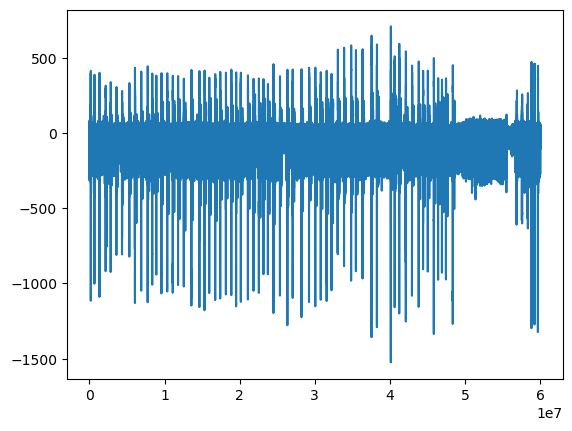

In [23]:
DataName = os.path.basename(raw_path).split(".")[0]
ch = "ch21"
channel_num = 1

#ここがいつもと違うところ。関数の域を抜けた。
raw_wave = np.fromfile(raw_path, dtype='h').reshape(-1,channel_num)
if channel_num == 1:
    raw_wave = raw_wave.squeeze() / 10  # 1列しかないのでそのまま 1 次元化
else:
    mask = CH_ARRAY == ch
    if not mask.any():
        raise ValueError(f"{ch} は CH_ARRAY に存在しません")
    raw_wave = raw_wave[:, mask][:, 0] / 10  # 指定チャンネルを取り出して 1 次元化

# raw_wave = raw[:, CH_ARRAY == ch][:, 0] / 10  # ここで1次元化

plt.plot(raw_wave)
plt.show()



In [24]:
filtered_wave = BandPassFilter(raw_wave)

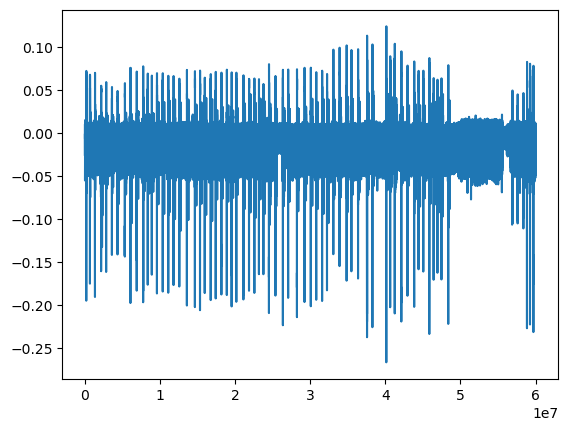

In [19]:
plt.plot(filtered_wave)


In [25]:
spike_index = SpikeDetection(filtered_wave)


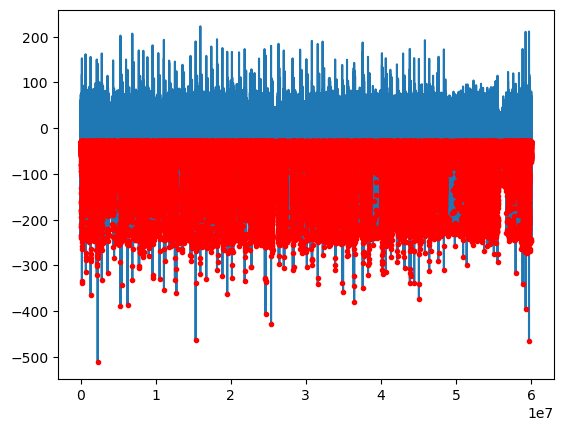

In [26]:
plt.plot(filtered_wave)
plt.plot(spike_index, filtered_wave[spike_index], 'r.')

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1.30443748, -1.04943986, -0.79444224, -0.53944462, -0.284447  ,
        -0.02944938,  0.22554824,  0.48054586,  0.73554348,  0.9905411 ,
         1.24553872,  1.50053634,  1.75553395,  2.01053157,  2.26552919,
         2.52052681,  2.77552443,  3.03052205,  3.28551967,  3.54051729,
         3.79551491,  4.05051253,  4.30551015,  4.56050777,  4.81550539,
         5.07050301,  5.32550063,  5.58049825,  5.83549587,  6.09049349,
         6.34549111,  6.60048873,  6.85548635,  7.11048397,  7.36548159,
         7.62047921,  7.87547683,  8.13047445,  8.38547207,  8.64046968,
         8.8954673 ]),
 array([-9.95469387, -9.44578018, -8.93686649, -8.42795281, -7.91903912,
        -7.41012543, -6.90121174, -6.39229806, -5.88338437, -5.37447068

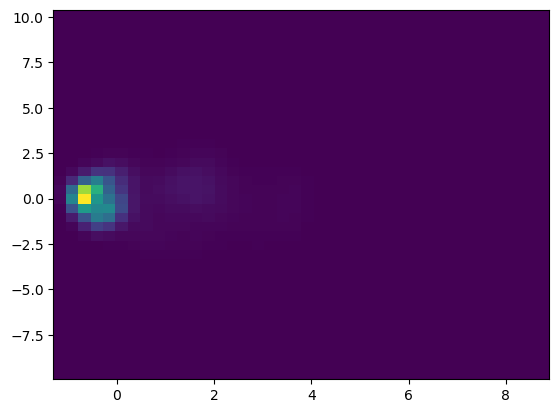

In [27]:
spike_shape, spike_index = GetWaveShape(spike_index, filtered_wave)

spike_shape_roi = CutWaveShape(spike_shape)
n_comp = 2
x_pca, variance = DimensionalityReductionWithDiffs(spike_shape_roi, n_comp)
spike_feature = StandardScaler().fit_transform(x_pca)

#PCA可視化
plt.scatter(spike_feature[:,0], spike_feature[:,1])
plt.hist2d(spike_feature[:,0], spike_feature[:,1], bins=40)

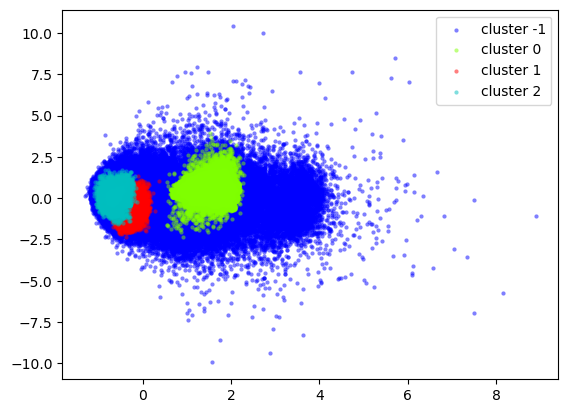

In [28]:
#クラスタリング
clusters = ClusteringWithHDBSCAN(spike_feature)
new_clusters = MargeCluster_TM(cluster = clusters, wave_shape = spike_shape, thr_marge = 115)
NEW_CLUSTERS = RescueNoise(cluster = new_clusters, wave_shape = CutWaveShape(spike_shape), thr_noise = 72)
for i, clu in enumerate(np.unique(NEW_CLUSTERS)):
    cluster_index = np.where(NEW_CLUSTERS == clu)[0]
    plt.scatter(spike_feature[cluster_index,0],spike_feature[cluster_index,1],
                c=COLOR[i],label=('cluster '+str(clu)),alpha=0.5,edgecolors=None, lw=0.01, marker='.')
plt.legend()

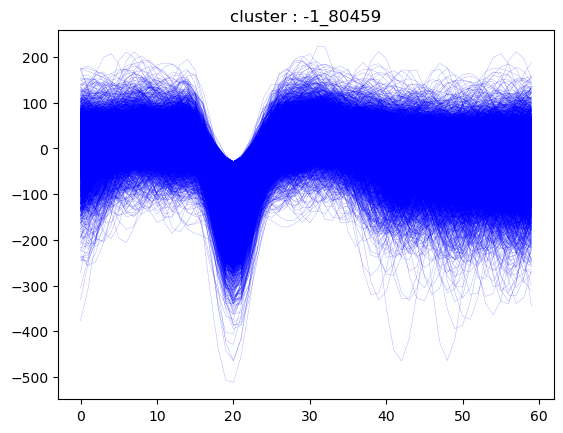

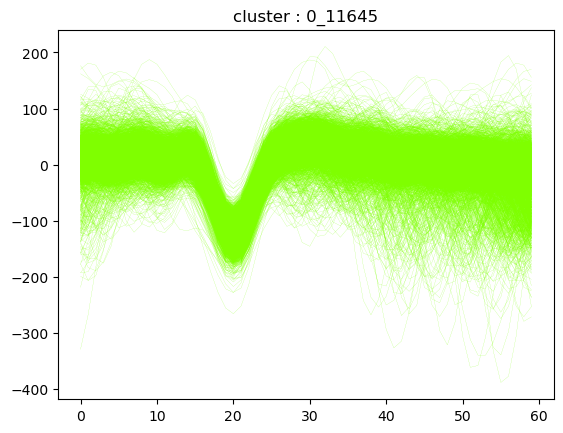

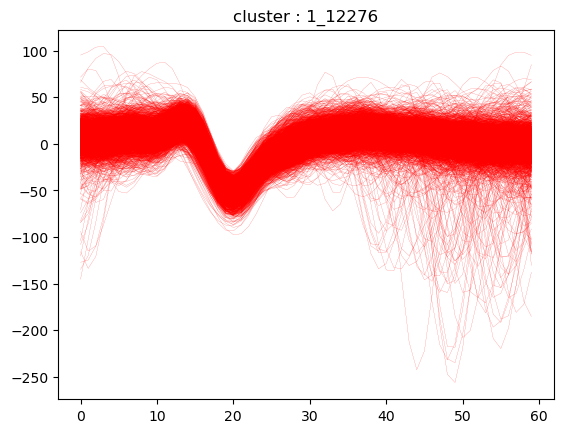

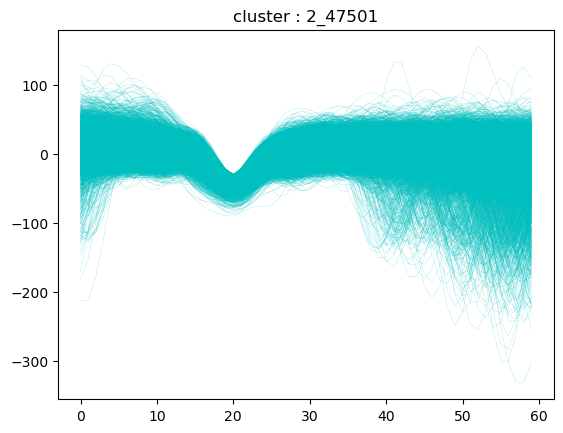

In [29]:
for i, clu in enumerate(np.unique(NEW_CLUSTERS)):
    cluster_index = np.where(NEW_CLUSTERS == clu)[0]
    plt.plot(spike_shape[cluster_index].T, c=COLOR[i], lw=0.1)
    plt.title('cluster : '+str(clu) + "_"+ str(spike_shape[cluster_index].T.shape[-1]))
    # plt.savefig(pca +"/" + DataName + "_" + ch + "_" + 'cluster'+str(clu) + "SpikeShape" + ".png")
    # plt.clf()
    # plt.close('all')
    plt.show()

In [35]:
#オートコレロ判定
CluNos = list(set(NEW_CLUSTERS))
spike_time = spike_index / 20
isi = np.c_[np.arange(1,spike_time.size+1), 
            spike_time, 
            np.diff(np.r_[0,spike_time]), 
            clusters]
isi

array([[ 1.00000000e+00,  1.58500000e+01,  1.58500000e+01,
        -1.00000000e+00],
       [ 2.00000000e+00,  5.83500000e+01,  4.25000000e+01,
        -1.00000000e+00],
       [ 3.00000000e+00,  6.02500000e+01,  1.90000000e+00,
         2.00000000e+00],
       ...,
       [ 1.51879000e+05,  3.00146750e+06,  2.42000000e+01,
         2.00000000e+00],
       [ 1.51880000e+05,  3.00158015e+06,  1.12650000e+02,
        -1.00000000e+00],
       [ 1.51881000e+05,  3.00164825e+06,  6.81000000e+01,
        -1.00000000e+00]])

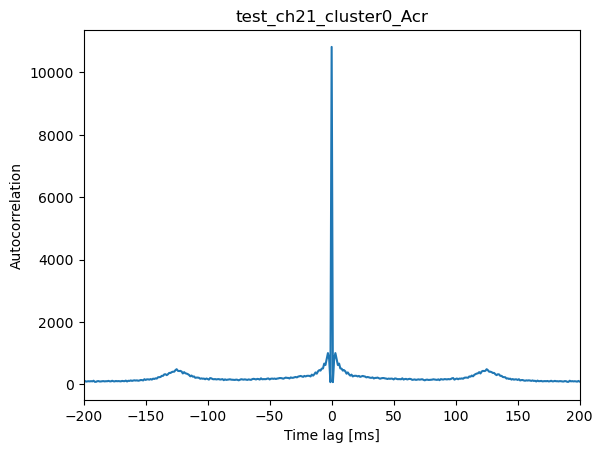

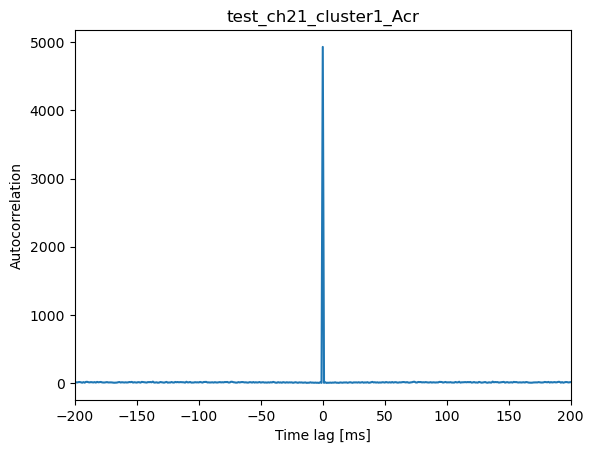

AutoCorrelo Clear!!


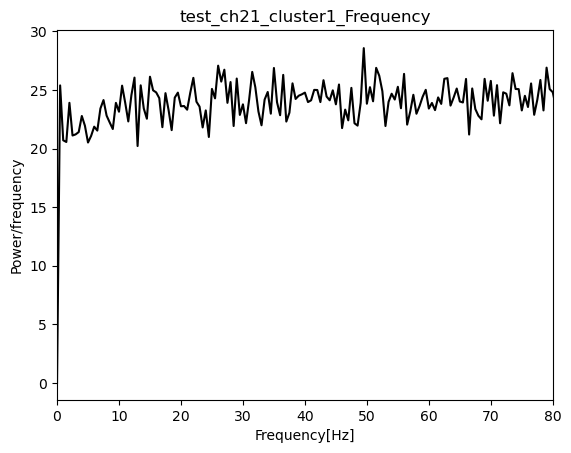

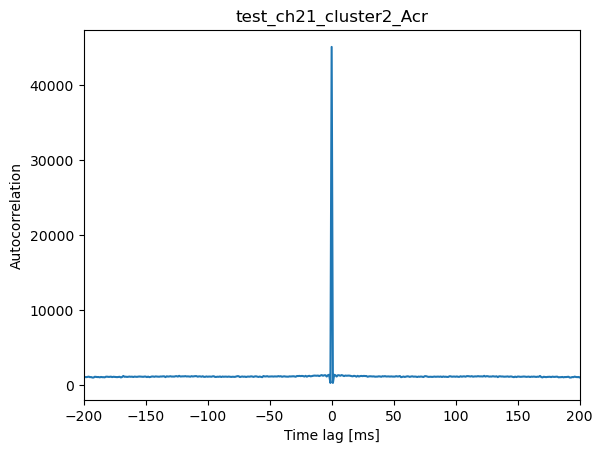

AutoCorrelo Clear!!


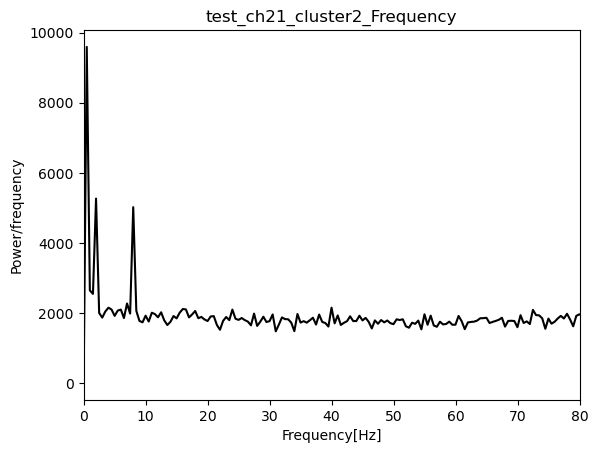

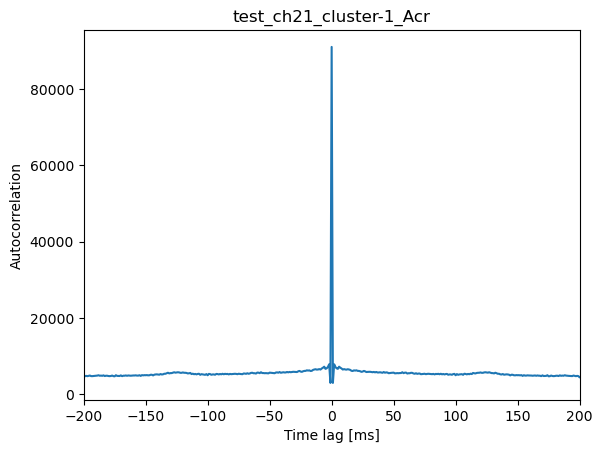

AutoCorrelo Clear!!


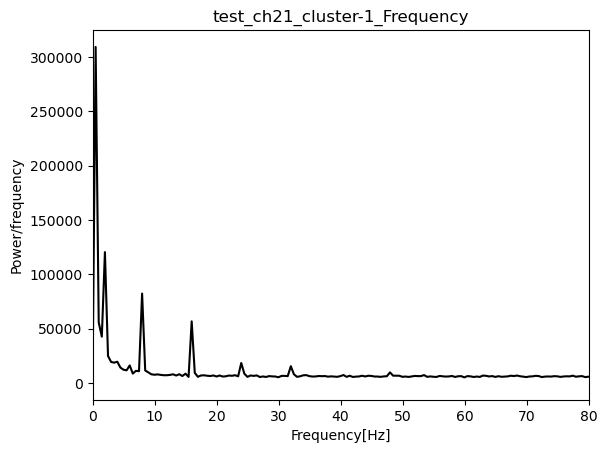

In [36]:
xAxis = np.arange(-1000,1001)

for CluNo in CluNos:
    temp_index = np.where(isi[:, 3] == CluNo)[0]
    temp_spike_time = isi[temp_index, 1]
    acr = CalcACR(temp_spike_time)
    FireIndex = JudgeAcr(xAxis, acr)
    plt.plot(xAxis, acr)
    plt.xlim(-200, 200)
    plt.xlabel("Time lag [ms]")
    plt.ylabel("Autocorrelation")
    plt.title(DataName + "_" + ch + "_" + 'cluster'+str(CluNo) + "_Acr")
    plt.savefig(auto_correlo +"/" + DataName + "_" + ch + "_" + 'cluster'+str(CluNo) + "_Acr" + ".png")
    # plt.clf()
    # plt.close('all')
    # print(FireIndex)
    plt.show()

    #基準値が1 %を上回場合は、そのクラスターを消去する。
    if FireIndex > 1:
        isi = np.delete(isi, temp_index, 0)
    else:
        print("AutoCorrelo Clear!!")
        freqP = CalcPOW(acr,ex_file_path='')
        freq = freqP[:, 0]
        P = freqP[:, 1]
        figure_pow = plt.figure()
        pow_pointer = figure_pow.add_subplot(1,1,1)
        pow_pointer.plot(freq,P,color='black')
        pow_pointer.set_xlim(0, 80)
        pow_pointer.set_xlabel('Frequency[Hz]')
        pow_pointer.set_ylabel('Power/frequency')
        # cell_id = os.path.split(ex_file_path)[1]
        pow_pointer.set_title(DataName + "_" + ch + "_" + 'cluster'+str(CluNo) + "_Frequency")
        #plt.ylim(0, 0.0007)
        plt.savefig(auto_correlo +"/" + DataName + "_" + ch + "_" + 'cluster'+str(CluNo) + "_Frequency" + ".png")
        # plt.clf()
        # plt.close('all')
        plt.show()

        
#             save_name = raw_path.split(".")[0] + "_" + ch
        np.save(sorting_cluster +"/" +  DataName + "_" + ch + "_" + "SpiktTime" + "Cluster_" +str(CluNo), isi[isi[:, 3] == CluNo])            #         isi[isi[:, 3] == CluNo])
